In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import statsmodels.api as sm
from scipy.stats import chi2
from torchmin import minimize
from torch.optim import Adam
import scipy.stats as stats

In [40]:

# Parameter für die Simulation
num_rats = 50 # Anzahl der Ratten
def time(t):
    return np.log(1 + (45 + t- 45)/10) # transformierte Alter
b_0 = 68.607
b_1 = 7.505
b_2 = 6.874
b_3 = 7.313
noise_var = 1.241
random_effect_0 = 1.743
random_effect_1 = 0.152

grouping = np.random.choice([1,2,3], size= num_rats)
# Indikatorvariablen
C = np.zeros(num_rats)
N = np.zeros(num_rats)
H = np.zeros(num_rats)

for i, group in enumerate(grouping):
    if group == 1:
        C[i] = 1
    if group == 2:
        N[i] = 1
    if group == 3:
        H[i] = 1


def simulate_dataset(num_patients):
    data = []
    data_we = []
    for patient_id in range(num_patients):
        # Randomly generate time points
        num_time_points = np.random.choice([4,5,6,7,8,9,10])
        time_points = [t * 10 for t in range(num_time_points)]

        gamma_0 = np.random.normal(0,random_effect_0 **2)
        gamma_1 = np.random.normal(0,random_effect_1 **2)
    
        for j,t in enumerate(time_points):
            # Generate noise
            noise = np.random.normal(0.0, np.sqrt(noise_var))
        
            # Simulate test score
            test_score = b_0 + gamma_0 + b_1 * N[patient_id] * time(t) \
                        + b_2 * H[patient_id] * time(t) \
                        + b_3 * C[patient_id] * time(t) \
                        + gamma_1 * time(t) + noise

            test_score_we =  b_0 + gamma_0 + b_1 * N[patient_id] * time(t) \
                        + b_2 * H[patient_id] * time(t) \
                        + b_3 * C[patient_id] * time(t) \
                        + gamma_1 * time(t) + noise
            data.append([patient_id,grouping[patient_id], t, time(t), test_score])
            data_we.append([patient_id,grouping[patient_id], t, time(t), test_score_we])
    return (data, data_we)

df = pd.DataFrame(simulate_dataset(num_rats)[0], columns=['patient_id','group', 'years_after_treatment','age', 'test_score'])
print(df)

     patient_id  group  years_after_treatment       age  test_score
0             0      1                      0  0.000000   65.509204
1             0      1                     10  0.693147   73.530609
2             0      1                     20  1.098612   77.807546
3             0      1                     30  1.386294   77.088302
4             0      1                     40  1.609438   78.135951
..          ...    ...                    ...       ...         ...
350          49      2                      0  0.000000   70.735208
351          49      2                     10  0.693147   77.406930
352          49      2                     20  1.098612   83.527468
353          49      2                     30  1.386294   80.659297
354          49      2                     40  1.609438   83.663123

[355 rows x 5 columns]


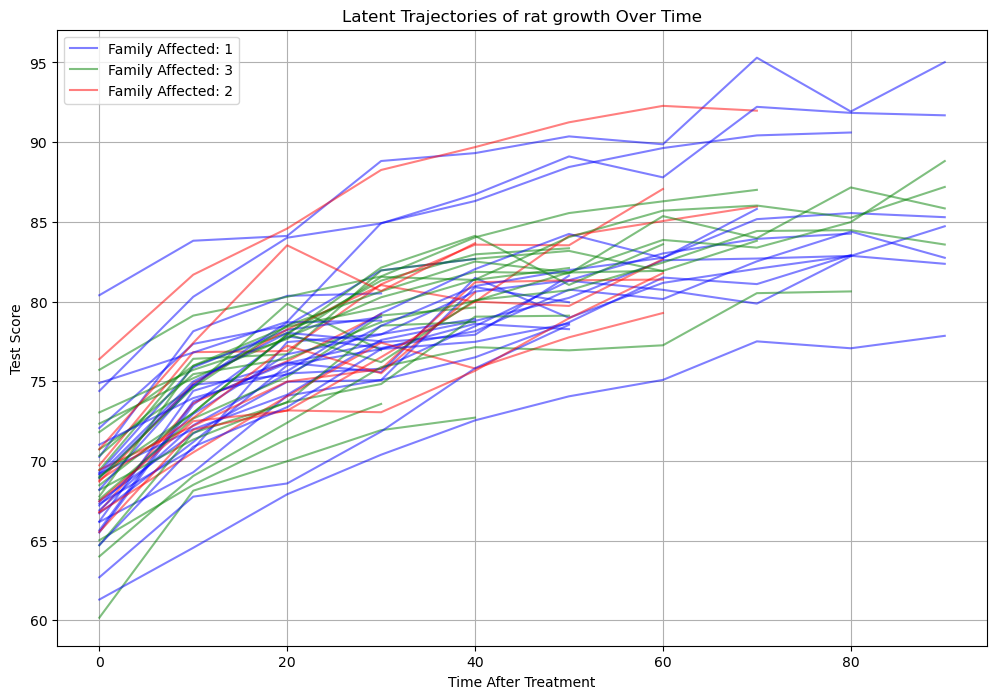

In [41]:
# plot the dataset

color_effect = 'group'

# Assuming you have your data in a DataFrame named 'df'
marker_map = {1: 'blue', 2: 'red', 3: 'green'} 

plt.figure(figsize=(12, 8))
# Create a set to track which labels have already been added to the legend
added_labels = set()


for patient_id in df['patient_id'].unique():
    patient_data = df[df['patient_id'] == patient_id]
    
    label = patient_data[color_effect].iloc[0]
    color = marker_map[label]

    # Check if the label has been added to the legend
    if label not in added_labels:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color, label=f'Family Affected: {label}')
        added_labels.add(label)
    else:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color)

plt.title('Latent Trajectories of rat growth Over Time')
plt.xlabel('Time After Treatment')
plt.ylabel('Test Score')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio(Lmin, Lmax, diff):
    L_diff = 2 * (Lmax - Lmin)
    return stats.chi2.sf(L_diff.detach().numpy(), diff)

In [46]:
#keys for random and fixed effects in the matrix
fixed_effects_keys = ['group', 'age']
random_effects_keys = ['years_after_treatment']

fixed_effects_keys_we = ['group', 'age']
random_effects_keys_we = ['years_after_treatment']

D_param = torch.randn(len(random_effects_keys) + 1, requires_grad=True)

softplus = torch.nn.Softplus()

def calculate_likelihood_df(df, fixed_effects, random_effects):
    n_fixed_eff = len(fixed_effects) + 1
    n_rand_eff = len(random_effects) + 1
    N = len(df)

    Z_list = calculate_Zlist(df, random_effects)

    D_param = torch.randn(n_rand_eff, requires_grad=True)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list = calculate_Xlist(df, fixed_effects)
    # Response variable: Test scores
    y = torch.from_numpy(np.array(df['test_score'])).to(torch.float32)

    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e = torch.cat([torch.cat((y[get_ind(pat, df)], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in df['patient_id'].unique()])

    # Ensure that the diagonal covariance matrix has only positive values
    Delta = torch.diag(softplus(D_param))
    det_Delta = torch.det(Delta)  

    # Defining list of Z tilde (eq. 2.7 p. 63)
    Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list]
    # Matrix X_e (eq. 2.11 p. 65)
    X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)

    # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
    pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e
    # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
    pred_sigma = torch.sum((y_e - X_e @ pred) ** 2) / N

    # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
    likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
    likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
    return - likelihood

# Alternative: Minimize the log-likelihood with 1st order optimizer
optimizer = Adam([D_param], lr=0.1)
for i in range(100):
    optimizer.zero_grad()
    likelihood = calculate_likelihood_df(df, fixed_effects_keys, random_effects_keys)
    likelihood.backward() 
    optimizer.step()  

In [49]:
num_datasets = 100
data_sets = []
data_sets_we = []
for i in range(num_datasets):
    data_sets.append(pd.DataFrame(simulate_dataset(50)[0], columns=['patient_id','group', 'years_after_treatment','age', 'test_score']))
    data_sets_we.append(pd.DataFrame(simulate_dataset(50)[1], columns=['patient_id','group', 'years_after_treatment','age', 'test_score']))


In [52]:
lrt_results = []
for i in range(num_datasets):
    L1 = calculate_likelihood_df(data_sets[i],fixed_effects_keys, random_effects_keys)
    L2 = calculate_likelihood_df(data_sets_we[i], fixed_effects_keys_we, random_effects_keys_we)
    lrt_results.append(likelihood_ratio(L2, L1, 1))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[6.627202821342282e-33, 1.3200787189783747e-33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.00014034130940713117, 1.0, 1.0, 1.0, 4.500493537209118e-25, 0.24744944222332696, 7.123694280141555e-29, 1.0, 0.5436730764936129, 1.0, 1.0, 1.0, 5.287267876625018e-16, 1.42745080641394e-24, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.4803405154748724e-10, 1.0, 2.2760543220880423e-26, 8.388628171918601e-07, 1.0, 1.0, 1.0, 2.4839474984739756e-27, 1.0, 3.068849941570088e-82, 1.1433784879336425e-35, 4.3028091438878654e-05, 5.556968260838883e-24, 1.0, 1.0, 5.590607925186945e-10, 1.0, 1.0, 3.0110462852474836e-28, 2.6817029440607723e-55, 1.0, 1.0, 1.0, 1.7757203540626253e-46, 1.0, 1.32739161347004e-22, 1.0, 6.953708193567216e-23, 3.2745409586355705e-29, 1.0, 1.0, 3.546919447633711e-23, 9.601785615841525e-32, 1.2058349132391823e-38, 8.440276819085719e-06, 3.120753562820515e-25, 1.0, 1.0, 1.0, 1.0, 1.1932793326009744e-86, 3.673377733946539e-32, 1.0, 1.1907588245770987e-12, 1.0, 1.0, 1.0, 1.0, 2.0916950458647586e-39, 1.0, 3.

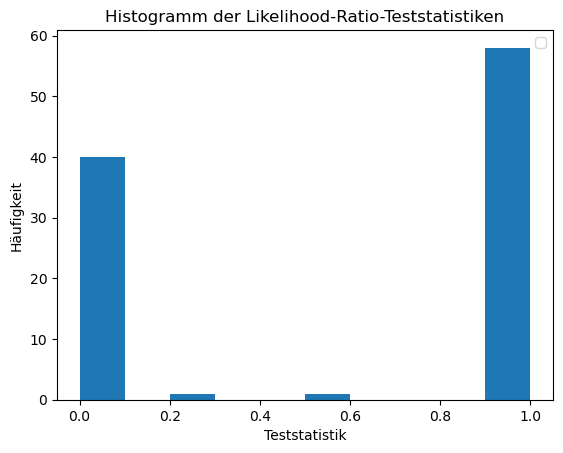

In [53]:
print(lrt_results)
# Histogramm der Teststatistiken erstellen
plt.hist(lrt_results)

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()